# Libraries

In [1]:
# libraries
from google.colab import drive
from google.colab import data_table

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.metrics import classification_report

from keras import Sequential, regularizers
from keras.layers import Dense, Dropout
from keras.callbacks import *
from keras.optimizers import *

# mount gdrive
drive.mount('/content/gdrive', force_remount=True)

# ignore warnings
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

Mounted at /content/gdrive


# Load dataset & Data Pre-Processing

In [2]:
# load dataset
dataset = pd.read_csv('/content/gdrive/MyDrive/IA/Dataset/ObesityDataSet.csv')

# make a copy, remove records with null fields
dataset = dataset.dropna()
dataset_bk = dataset.copy()

# enconding the non-numerical values, it's needed because of the neural network's fit method
# otherwise -> 'ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).'
label_encoder = LabelEncoder()
dataset['Gender'] = label_encoder.fit_transform(dataset['Gender'])
dataset['family_history_with_overweight'] = label_encoder.fit_transform(dataset['family_history_with_overweight'])
dataset['FAVC'] = label_encoder.fit_transform(dataset['FAVC'])
dataset['CAEC'] = label_encoder.fit_transform(dataset['CAEC'])
dataset['SMOKE'] = label_encoder.fit_transform(dataset['SMOKE'])
dataset['SCC'] = label_encoder.fit_transform(dataset['SCC'])
dataset['CALC'] = label_encoder.fit_transform(dataset['CALC'])
dataset['MTRANS'] = label_encoder.fit_transform(dataset['MTRANS'])

# Normal_Weight | Insufficient_Weight | Overweight_Level_I | Overweight_Level_II
dataset_1 = dataset.loc[dataset['NObeyesdad'] == 'Normal_Weight']
dataset_2 = dataset.loc[dataset['NObeyesdad'] == 'Insufficient_Weight']
dataset_3 = dataset.loc[dataset['NObeyesdad'] == 'Overweight_Level_I']
dataset_4 = dataset.loc[dataset['NObeyesdad'] == 'Overweight_Level_II']
dataset_normalw = pd.concat([dataset_1, dataset_2, dataset_3, dataset_4], ignore_index=True)
dataset_normalw['NObeyesdad'] = 0

# Obesity_Type_I | Obesity_Type_II | Obesity_Type_III
dataset_5 = dataset.loc[dataset['NObeyesdad'] == 'Obesity_Type_I']
dataset_6 = dataset.loc[dataset['NObeyesdad'] == 'Obesity_Type_II']
dataset_7 = dataset.loc[dataset['NObeyesdad'] == 'Obesity_Type_III']
dataset_obesew = pd.concat([dataset_5, dataset_6, dataset_7], ignore_index=True)
dataset_obesew['NObeyesdad'] = 1

# concat
dataset = pd.concat([dataset_normalw, dataset_obesew], ignore_index=True)

# round values
dataset['Age'] = dataset['Age'].round(decimals=0).astype(int)
dataset['Height'] = dataset['Height'].round(decimals=2)
dataset['Weight'] = dataset['Weight'].round(decimals=2)
dataset['FCVC'] = dataset['FCVC'].round(decimals=0).astype(int)
dataset['NCP'] = dataset['NCP'].round(decimals=0).astype(int)
dataset['CH2O'] = dataset['CH2O'].round(decimals=0).astype(int)
dataset['FAF'] = dataset['FAF'].round(decimals=0).astype(int)
dataset['TUE'] = dataset['TUE'].round(decimals=0).astype(int)

# renames
dataset.rename(columns={"family_history_with_overweight": "FHO"}, inplace=True)
dataset.rename(columns={"NObeyesdad": "OBESE"}, inplace=True)

# shuffle 
dataset = dataset.sample(frac=1).reset_index(drop=True)

# print the dataset
data_table.DataTable(dataset, include_index=False, num_rows_per_page=10)

,Gender,Age,Height,Weight,FHO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,OBESE
0,0,20,1.77,138.14,1,1,3,3,2,0,3,0,2,1,2,3,1
1,1,30,1.76,112.01,1,1,2,3,2,0,2,0,0,0,2,0,1
2,1,33,1.75,85.00,0,0,2,3,2,0,2,1,1,0,2,3,0
3,0,22,1.65,65.00,1,1,2,3,1,0,2,1,1,0,3,0,0
4,1,27,1.79,112.74,1,1,2,3,2,0,2,0,0,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,22,1.61,67.94,1,1,2,4,2,0,3,0,2,1,2,3,0
2107,0,26,1.62,104.99,1,1,3,3,2,0,2,0,0,1,2,3,1
2108,0,22,1.66,121.21,1,1,3,3,2,0,1,0,0,0,2,3,1
2109,1,24,1.70,84.85,1,1,2,3,2,0,2,0,0,1,2,3,0


# Dataset Mapping Description 

In [3]:
# get the mapping of the label encoded
le = LabelEncoder()
le.fit(dataset_bk['Gender'])
le_name_map_1 = dict(zip(le.classes_, le.transform(le.classes_)))
le.fit(dataset_bk['family_history_with_overweight'])
le_name_map_2 = dict(zip(le.classes_, le.transform(le.classes_)))
le.fit(dataset_bk['FAVC'])
le_name_map_3 = dict(zip(le.classes_, le.transform(le.classes_)))
le.fit(dataset_bk['CAEC'])
le_name_map_4 = dict(zip(le.classes_, le.transform(le.classes_)))
le.fit(dataset_bk['SMOKE'])
le_name_map_5 = dict(zip(le.classes_, le.transform(le.classes_)))
le.fit(dataset_bk['SCC'])
le_name_map_5 = dict(zip(le.classes_, le.transform(le.classes_)))
le.fit(dataset_bk['CALC'])
le_name_map_6 = dict(zip(le.classes_, le.transform(le.classes_)))
le.fit(dataset_bk['MTRANS'])
le_name_map_7 = dict(zip(le.classes_, le.transform(le.classes_)))

# style
class color:
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# features legend
print(color.BOLD + 'Features legend:' + color.END)
print('FAVC\t -> Frequent consumption of high caloric food')
print('FCVC\t -> Frequency of consumption of vegetables')
print('NCP\t -> Number of main meals')
print('CAEC\t -> Consumption of food between meals')
print('CH20\t -> Consumption of water daily')
print('CALC\t -> Consumption of alcohol')
print('SCC\t -> Calories consumption monitoring')
print('FAF\t -> Physical activity frequency')
print('TUE\t -> Time using technology devices')
print('MTRANS\t -> Transportation used')
print('')

# encoding mapping
print(color.BOLD + 'Dataset encoding mapping:' + color.END)
print(f'GENDER\t -> {le_name_map_1}')
print(f'FHO\t -> {le_name_map_2}')
print(f'FAVC\t -> {le_name_map_3}')
print("FCVC\t -> {'Never': 1, 'Sometimes': 2, 'Always': 3}")
print(f'CAEC\t -> {le_name_map_4}')
print(f'SMOKE\t -> {le_name_map_5}')
print("CH2O\t -> {'> 2L': 1, '1-2L': 2, '< 1L': 3}")
print(f'SCC\t -> {le_name_map_5}')
print("FAF\t -> {'4-5gg': 0, '2-4gg': 1, '1-2gg': 2, 'never': 3}")
print("TUE\t -> {'> 5h': 0, '3-5h': 1, '0-2h': 2}")
print(f'CALC\t -> {le_name_map_6}')
print(f'MTRANS\t -> {le_name_map_7}')

Features legend:
FAVC	 -> Frequent consumption of high caloric food
FCVC	 -> Frequency of consumption of vegetables
NCP	 -> Number of main meals
CAEC	 -> Consumption of food between meals
CH20	 -> Consumption of water daily
CALC	 -> Consumption of alcohol
SCC	 -> Calories consumption monitoring
FAF	 -> Physical activity frequency
TUE	 -> Time using technology devices
MTRANS	 -> Transportation used

Dataset encoding mapping:
GENDER	 -> {'Female': 0, 'Male': 1}
FHO	 -> {'no': 0, 'yes': 1}
FAVC	 -> {'no': 0, 'yes': 1}
FCVC	 -> {'Never': 1, 'Sometimes': 2, 'Always': 3}
CAEC	 -> {'Always': 0, 'Frequently': 1, 'Sometimes': 2, 'no': 3}
SMOKE	 -> {'no': 0, 'yes': 1}
CH2O	 -> {'> 2L': 1, '1-2L': 2, '< 1L': 3}
SCC	 -> {'no': 0, 'yes': 1}
FAF	 -> {'4-5gg': 0, '2-4gg': 1, '1-2gg': 2, 'never': 3}
TUE	 -> {'> 5h': 0, '3-5h': 1, '0-2h': 2}
CALC	 -> {'Always': 0, 'Frequently': 1, 'Sometimes': 2, 'no': 3}
MTRANS	 -> {'Automobile': 0, 'Bike': 1, 'Motorbike': 2, 'Public_Transportation': 3, 'Walking': 4}


# Exploratory Data Analysis (EDA)

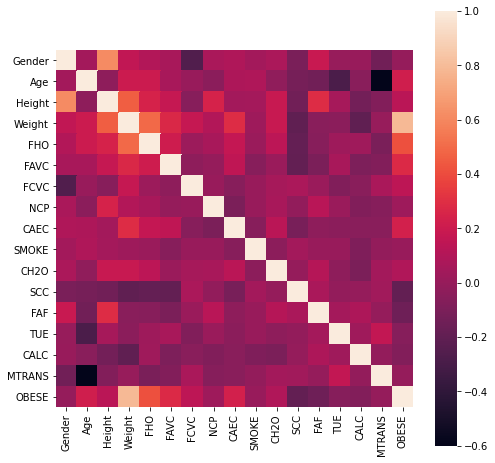

In [4]:
# correlation matrix
corrmat = dataset.corr()
plt.subplots(figsize=(8,8))
sns.heatmap(corrmat, vmax=1, square=True)

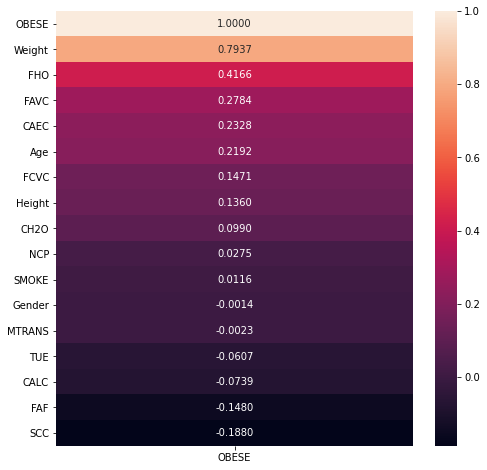

In [5]:
# correlation table ordered
corr_obese = dataset.corrwith(dataset['OBESE'], axis=0)
corr_obese = pd.DataFrame(corr_obese)
corr_obese.rename(columns = {0: 'OBESE'}, inplace = True)
corr_obese.sort_values(by=['OBESE'], ascending=False, inplace = True)

plt.subplots(figsize=(8,8))
# color map alterantive -> cmap="GnBu"
sns.heatmap(corr_obese, vmax=1, fmt='.4f', annot=True)

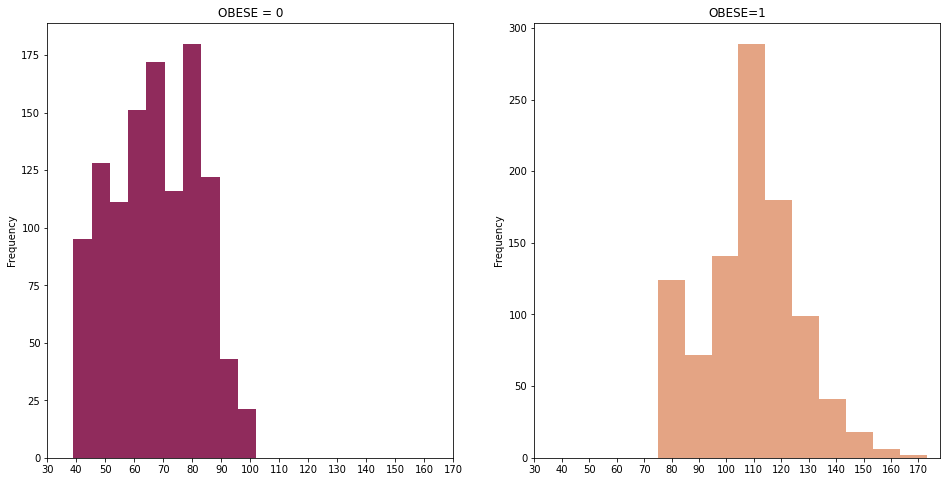

In [6]:
# Correlation between Weight and OBESE
f,ax = plt.subplots(1, 2, figsize=(16,8))

dataset.loc[dataset['OBESE']==0]['Weight'].plot.hist(ax=ax[0], bins=10, color='#902b5c')
ax[0].set_title('OBESE = 0')
ax1 = list(range(30, 180, 10))
ax[0].set_xticks(ax1)

dataset[dataset['OBESE']==1]['Weight'].plot.hist(ax=ax[1], bins=10, color='#e4a484')
ax[1].set_title('OBESE=1')
x2=list(range(30, 180, 10))
ax[1].set_xticks(x2)

plt.show()

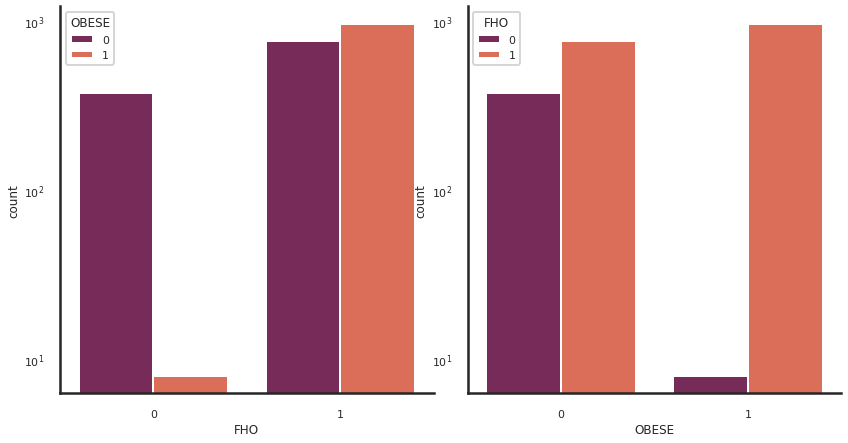

In [7]:
# Correlation between CAEC and OBESE
# FHO = Consumption of food between meals
# 0 -> No | 1 -> Yes 

fig = plt.figure(figsize=(14,11))
gs = fig.add_gridspec(3,4)
sns.set_style("white")
sns.set_context("poster", font_scale = 0.5)

ax_caec_obese = fig.add_subplot(gs[:2,:2])
sns.countplot(x='FHO', hue='OBESE', data=dataset, ax=ax_caec_obese, palette='rocket')
sns.despine()

ax_caec_obese = fig.add_subplot(gs[:2,2:4], sharey=ax_caec_obese)
sns.countplot(x='OBESE', hue='FHO', data=dataset, ax=ax_caec_obese, palette='rocket')
sns.despine()

ax_caec_obese.set_yscale('log')

plt.show()

# Dataset splitting

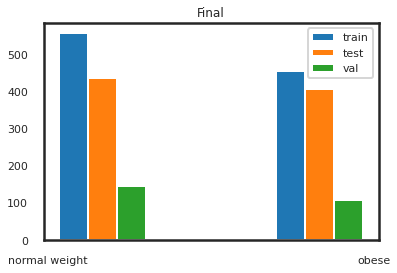


-> train set: 1012 | test set: 845 | validation set: 254



In [8]:
# getting labels from the dataset and dropping the columns
data_targets = dataset['OBESE']
data = dataset.drop('OBESE', axis=1) 

# splitting (test = 0.4 | val = 0.2)
x_train_val, x_test, y_train_val, y_test = train_test_split(data, data_targets, test_size=0.4)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2)

# plot the labels's distribution
plt.hist([y_train, y_test, y_val], bins=3, label=['train', 'test', 'val'])
plt.xticks([0,1],['normal weight','obese'])
plt.legend(loc='upper right')
plt.title('Final')
plt.show()

# print the lengths
print(f'\n-> train set: {len(x_train)} | test set: {len(x_test)} | validation set: {len(x_val)}\n')

# Neural Network for tabular data

In [9]:
# clear session
tf.keras.backend.clear_session()

# sequential model
classifier = Sequential()

classifier.add(Dense(32,  activation='ReLU', kernel_regularizer=regularizers.l2(0.01), input_shape=(16,)))
classifier.add(Dropout(.2))
classifier.add(Dense(32,  activation='ReLU', kernel_regularizer=regularizers.l2(0.01)))
classifier.add(Dropout(.2))
classifier.add(Dense(1,   activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

# summary
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [10]:
# compiling
opt = Adam(learning_rate=1e-3)
classifier.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# weights path
best_weights_filepath = './xai_nn_obesity.hdf5'
saveBestModel = ModelCheckpoint(best_weights_filepath, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             mode='min', 
                             factor=0.1, 
                             patience=10,
                             verbose=1)
earlyStop = EarlyStopping(monitor='val_loss', 
                          patience=10, 
                          restore_best_weights=False,
                          verbose=1)

# training
history = classifier.fit(x_train, y_train, 
                      #batch_size=16, 
                      epochs=100,
                      validation_data=(x_val, y_val),
                      callbacks=[saveBestModel, reduceLR, earlyStop])

# load best weights
classifier.load_weights(best_weights_filepath)

Epoch 1/100
32/32 [==============================] - 14s 20ms/step - loss: 2.4398 - accuracy: 0.5504 - val_loss: 1.0247 - val_accuracy: 0.6969

Epoch 00001: val_loss improved from inf to 1.02470, saving model to ./xai_nn_obesity.hdf5
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 1.5101 - accuracy: 0.5942 - val_loss: 0.9244 - val_accuracy: 0.7244

Epoch 00002: val_loss improved from 1.02470 to 0.92442, saving model to ./xai_nn_obesity.hdf5
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 1.2498 - accuracy: 0.6329 - val_loss: 0.7877 - val_accuracy: 0.7598

Epoch 00003: val_loss improved from 0.92442 to 0.78765, saving model to ./xai_nn_obesity.hdf5
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 1.0479 - accuracy: 0.6452 - val_loss: 0.7355 - val_accuracy: 0.7835

Epoch 00004: val_loss improved from 0.78765 to 0.73555, saving model to ./xai_nn_obesity.hdf5
Epoch 5/100
32/32 [==============================] - 0s 2m

# Evaluate the results

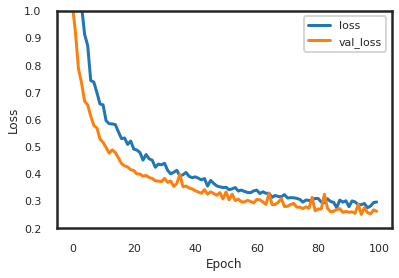

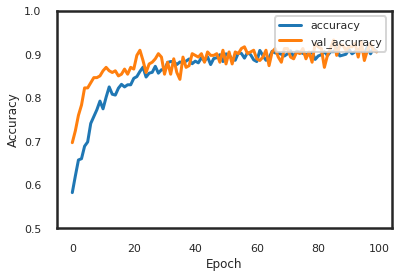

27/27 [==============================] - 0s 1ms/step - loss: 0.2656 - accuracy: 0.9065
test loss, test acc: [0.26563921570777893, 0.9065088629722595]


In [11]:
#plot graphs for loss function and metrics
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.2, 1])
#plt.xlim([0, 45])
#plt.xscale('log')
plt.legend(loc='upper right')
plt.show() 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.show()

# evaluating
results = classifier.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# Predictions 

In [12]:
# create array of predictions (maybe there's a better way to do it)
#y_pred = model.predict(x_test)
#y_pred = y_pred > 0.5
y_pred=[]

for i in classifier.predict(x_test):
    if i>0.5: y_pred.append(1)
    if i<0.5: y_pred.append(0)

# confusion matrix v.1
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
c_scores = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
accuracy = (tp + tn) / (tn + fp + fn + tp)

# confusion matrix v.2
c_matrix = confusion_matrix(y_test, y_pred)

print(c_scores, end='\n\n')
print(c_matrix, end='\n\n')
print(f'accuracy = {accuracy}')

{'tn': 417, 'fp': 20, 'fn': 59, 'tp': 349}

[[417  20]
 [ 59 349]]

accuracy = 0.906508875739645


# Create the new Dataset for PROLOG XAI

In [13]:
# join the x_test with the y_pred
# get a copy 
new_data = x_test

# add 'labels' array as new column in DataFrame
new_data['PRED_OBESE'] = y_pred
#new_data['OBESE'] = y_test

# export the dataset in .csv format
#new_data.to_csv('./neural_network_obese.csv', index=False, header=False)

# def function to write facts on .pl file 
def write_pl_database(data):
  file_w = open(r'./nn_obese_database.pl', 'w')
  column_name = list(data.columns)
  for index, row in data.iterrows():
    line = f"a({row[column_name[0]].astype(int)},{row[column_name[1]].astype(int)},{row[column_name[2]].astype(float)},{row[column_name[3]].astype(float)},{row[column_name[4]].astype(int)},{row[column_name[5]].astype(int)},{row[column_name[6]].astype(int)},{row[column_name[7]].astype(int)},{row[column_name[8]].astype(int)},{row[column_name[9]].astype(int)},{row[column_name[10]].astype(int)},{row[column_name[11]].astype(int)},{row[column_name[12]].astype(int)},{row[column_name[13]].astype(int)},{row[column_name[14]].astype(int)},{row[column_name[15]].astype(int)},{row[column_name[16]].astype(int)})."
    #line = f"a({row[:-1].values})."
    file_w.write(line)
    file_w.write("\n")
  file_w.close()

# writing...
new_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Gender,Age,Height,Weight,FHO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,PRED_OBESE
1924,1,31,1.74,82.52,1,1,2,3,2,0,2,0,0,0,2,0,0
80,0,18,1.59,53.00,0,0,1,3,2,0,1,0,1,2,3,3,0
1381,1,22,1.75,105.00,1,1,3,3,2,0,3,0,1,0,2,3,1
1862,1,18,1.78,108.00,1,0,2,3,2,0,3,0,1,0,3,3,1
107,0,19,1.55,69.94,1,0,3,3,2,0,1,0,1,1,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1,18,1.82,108.74,1,1,2,1,2,0,2,0,1,1,3,3,1
1507,1,17,1.77,55.70,1,1,2,4,2,0,3,0,2,1,2,3,0
271,0,26,1.67,104.77,1,1,3,3,2,0,2,0,0,1,2,3,1
1982,0,38,1.56,80.00,1,1,3,1,2,0,2,0,1,0,2,0,0


# Decision Tree Classifier

In [15]:
use_data = new_data.copy()

# preparing the dataset
tree_labels = use_data['PRED_OBESE']
tree_data = use_data.drop('PRED_OBESE', axis=1)

x_train, x_test, y_train, y_test = train_test_split(tree_data, tree_labels, test_size=0.33)

# two models for gini and information gain
model_tree = tree.DecisionTreeClassifier(criterion='gini')
model_tree_2 = tree.DecisionTreeClassifier(criterion='entropy')

# fit and predictions
model_tree.fit(x_train, y_train)
predictions = model_tree.predict(x_test)

model_tree_2.fit(x_train, y_train)
predictions2 = model_tree_2.predict(x_test)

# metrics
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

print(classification_report(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       159
           1       0.92      0.93      0.93       120

    accuracy                           0.94       279
   macro avg       0.93      0.94      0.93       279
weighted avg       0.94      0.94      0.94       279

[[149  10]
 [  8 112]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       159
           1       0.93      0.95      0.94       120

    accuracy                           0.95       279
   macro avg       0.94      0.95      0.95       279
weighted avg       0.95      0.95      0.95       279

[[150   9]
 [  6 114]]


In [16]:
text_representation = tree.export_text(decision_tree=model_tree,
                                       feature_names=tree_data.columns.tolist())
print(text_representation)

|--- Weight <= 88.11
|   |--- Weight <= 81.19
|   |   |--- Weight <= 80.52
|   |   |   |--- class: 0
|   |   |--- Weight >  80.52
|   |   |   |--- Weight <= 80.56
|   |   |   |   |--- class: 1
|   |   |   |--- Weight >  80.56
|   |   |   |   |--- class: 0
|   |--- Weight >  81.19
|   |   |--- Height <= 1.66
|   |   |   |--- FCVC <= 2.50
|   |   |   |   |--- FAF <= 1.50
|   |   |   |   |   |--- Age <= 18.50
|   |   |   |   |   |   |--- CH2O <= 1.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- CH2O >  1.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Age >  18.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- FAF >  1.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- FCVC >  2.50
|   |   |   |   |--- Weight <= 85.18
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Weight >  85.18
|   |   |   |   |   |--- class: 1
|   |   |--- Height >  1.66
|   |   |   |--- Age <= 17.50
|   |   |   |   |--- class: 1
|   |   |   |--- Ag

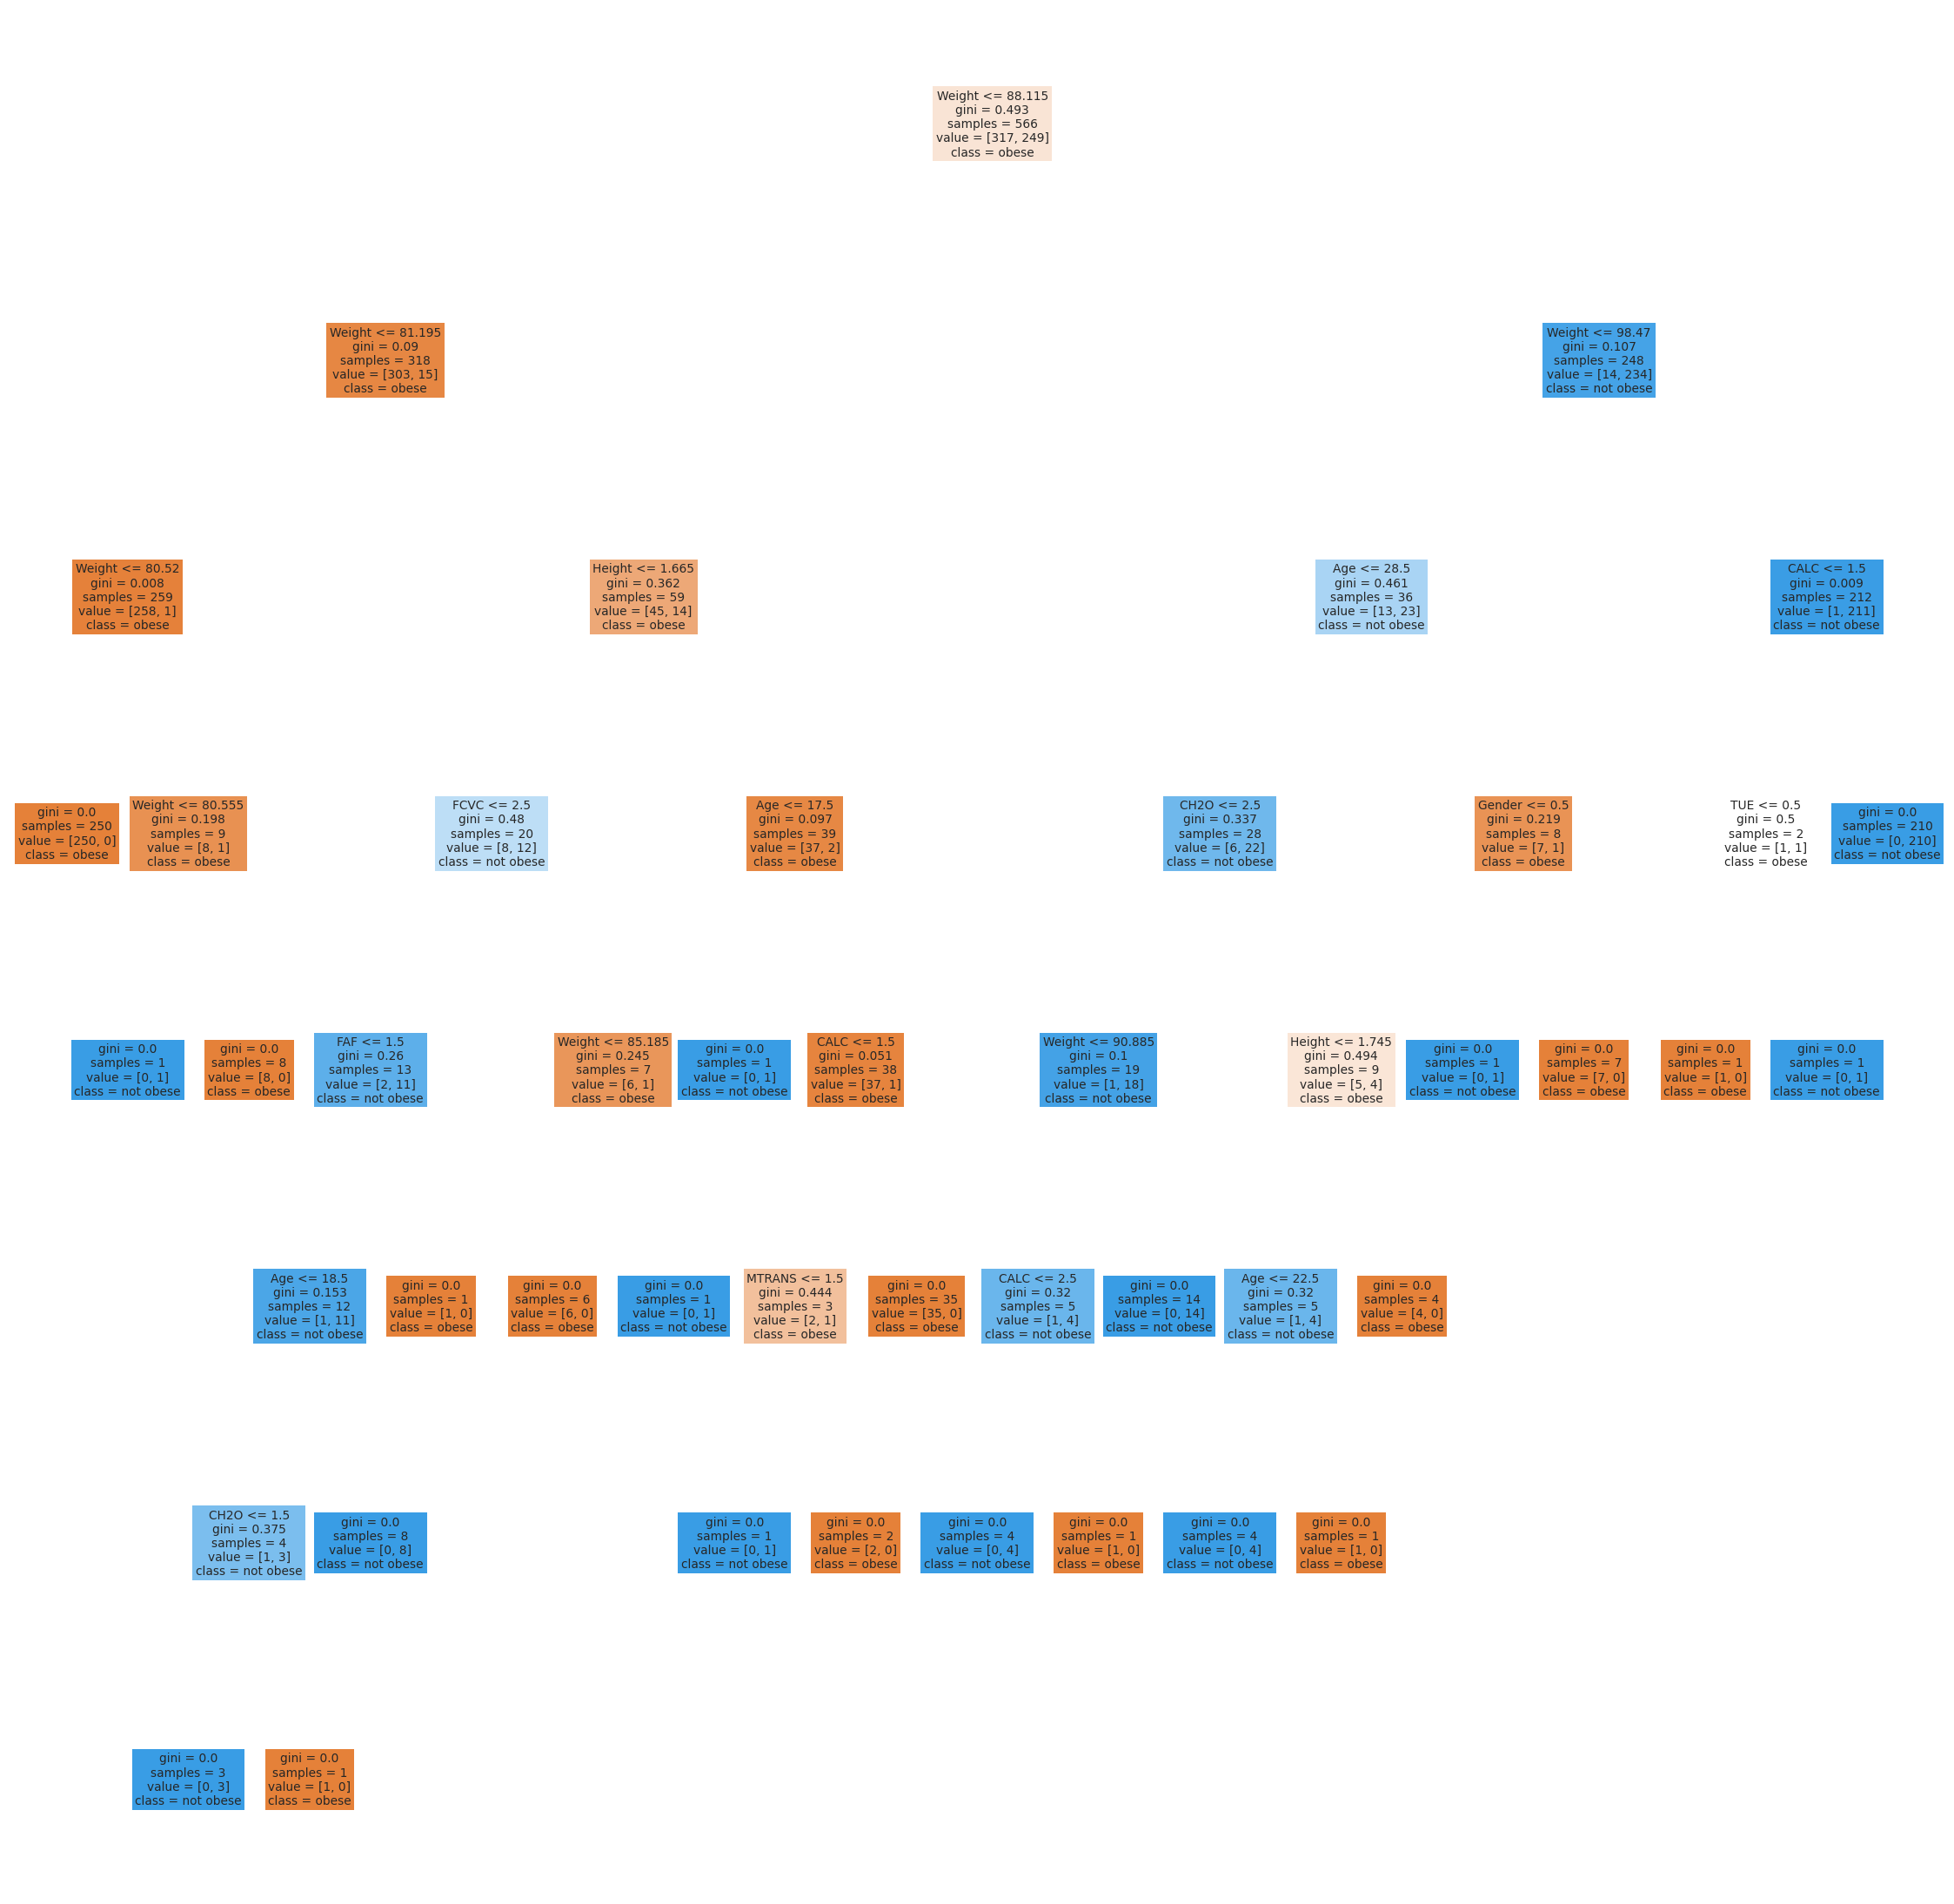

In [18]:
from sklearn import tree

fig = plt.figure(figsize=(40,40))
_ = tree.plot_tree(model_tree, 
                   feature_names=tree_data.columns,  
                   class_names=['obese','not obese'],
                   filled=True)